In [1]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
datestr = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

In [3]:
def rho_w(T):#density of water kg/m3 at T deg C
    #10.1088/0026-1394/38/4/3
    a = [-3.983035,301.797,522528.9,69.34881,999.97495]
    return a[4]*(1-(T+a[0])**2*(T+a[1])/a[2]/(T+a[3]))
def latent(T):#latent heat of vaporization kJ/kg at T deg C
    return 2501 - 0002.361 * T
def vpd(rh,t):
    #tetens
    es = esa(t)
    return es *(1- rh / 100)

def esa(T):#saturation vapor pressure kPa, T is temp in deg C
    return  0.61078 * np.exp((17.269 * T) / (237.3 + T))

In [4]:
cook_flux = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Meteorological/Cook/EcTower/REddyProc/CookEast/6503_20240805_REP_output.csv',skiprows=[1,2],sep='\t').replace(to_replace=-9999,value=np.nan)

In [5]:
cook_hy2023_v1 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cookhy2023_V1_pa_output.csv')
cook_hy2023_v2 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cookhy2023_V2_pa_output.csv')
cook_hy2024_v3 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cookhy2024_V3_pa_output.csv')

In [6]:
cook_hy2024_v3

,Unnamed: 0,times,daylight,elevation,azimuth,fssun,fsshd,frsun,frshd,fvsun,...,fwsun,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd
0,0,2023-09-08 20:19:11+00:00,True,41.835873,192.456858,0.001777,0.179339,0.806289,0.012066,0.000310,...,0.000032,0.000069,310.533009,310.320576,310.713005,310.262299,309.657841,309.191796,307.771195,308.451448
1,1,2023-09-08 21:19:12+00:00,True,45.861737,213.292897,0.001140,0.191644,0.794433,0.012432,0.000341,...,0.000000,0.000002,311.891962,311.934387,312.410928,311.884771,311.243594,310.167592,NaN,310.691703
2,2,2023-09-08 22:19:12+00:00,True,52.763931,230.812548,0.001234,0.222461,0.761539,0.014210,0.000436,...,0.000000,0.000064,314.067232,314.410289,315.015492,313.983638,312.927011,310.777097,NaN,310.795703
3,3,2023-09-08 23:19:13+00:00,True,61.485658,245.284345,0.003277,0.279320,0.696015,0.020116,0.000858,...,0.000076,0.000266,309.741596,309.478300,309.984780,309.303439,308.867572,307.158053,306.360675,306.727085
4,4,2023-09-09 00:19:14+00:00,True,71.213228,257.668459,0.007498,0.375954,0.581154,0.032434,0.002028,...,0.000047,0.000645,307.055205,307.181911,307.582561,306.946161,306.721666,306.503824,307.138560,306.401879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,4348,2024-07-10 12:09:18+00:00,False,89.757213,56.278251,0.000000,0.158225,0.000000,0.189097,0.000000,...,0.000000,0.000144,NaN,296.357513,NaN,296.352863,NaN,296.466773,NaN,296.435334
4349,4349,2024-07-10 13:09:21+00:00,False,81.145755,66.887210,0.000000,0.158225,0.000000,0.189097,0.000000,...,0.000000,0.000144,NaN,296.855460,NaN,296.825696,NaN,296.910703,NaN,296.825175
4350,4350,2024-07-10 14:09:26+00:00,True,71.432031,77.093499,0.001476,0.350313,0.000590,0.002053,0.248250,...,0.000006,0.000082,299.441863,299.440011,299.424017,299.457429,299.436185,299.449841,NaN,299.517026
4351,4351,2024-07-10 15:09:31+00:00,True,61.277254,87.468228,0.001324,0.197751,0.006242,0.007038,0.373379,...,0.000009,0.000041,302.468438,302.468734,302.427423,302.460939,302.426889,302.431963,NaN,302.442195


In [7]:
cook_hy2023_v1['times'] = pd.to_datetime(cook_hy2023_v1.times)
cook_hy2023_v2['times'] = pd.to_datetime(cook_hy2023_v2.times)
cook_hy2024_v3['times'] = pd.to_datetime(cook_hy2024_v3.times)

In [8]:
cook_hys = pd.concat([cook_hy2023_v1,cook_hy2023_v2,cook_hy2024_v3]).reset_index()

In [9]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Rg', 'Tair', 'rH', 'VPD', 'LE_uStar_f']]
cook_flux['lambda']=cook_flux.Tair.apply(latent)
cook_flux['rho_w']=cook_flux.Tair.apply(rho_w)

In [10]:
cook_flux['ET']=cook_flux['LE_uStar_f']/cook_flux['lambda']/cook_flux['rho_w']*60*30#mm H20 in 30min
cook_flux['Minutes']=60*(cook_flux['Hour']-np.floor(cook_flux['Hour']))

In [11]:
cook_flux['Hour']=np.floor(cook_flux['Hour'])

In [12]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Minutes', 'Rg', 'Tair', 'rH', 'VPD','ET']]

In [13]:
cook_flux['times']=pd.to_datetime(cook_flux['Year'].astype(str) + ' ' + cook_flux['DoY'].astype(str) + ' ' + cook_flux['Hour'].astype(int).astype(str)+':'+cook_flux['Minutes'].astype(int).astype(str),
    format='%Y %j %H:%M'
   )

In [14]:
#half-hourly to hourly
cook_flux=cook_flux.groupby(['Year','DoY','Hour']).agg({'times':'max', 'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'VPD':'mean', 'ET':'sum'}).reset_index()

In [15]:
cook_flux['times'] = cook_flux.times.dt.tz_localize('Etc/GMT+8')

In [16]:
cook_flux['times'] = cook_flux.times.dt.tz_convert('UTC')

In [17]:
#should check tz's match

In [18]:
cook_flux.Tair+=273.15

<Axes: xlabel='times'>

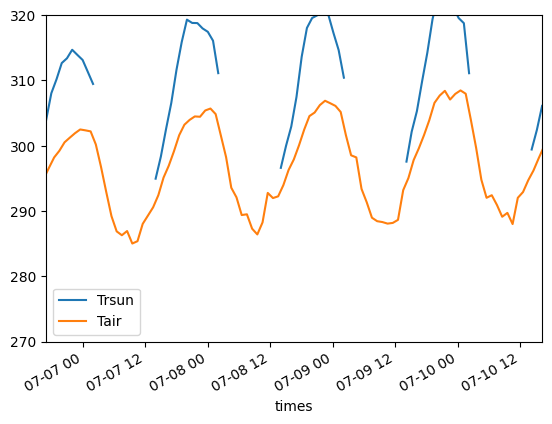

In [19]:
ax = cook_hys.plot(x='times',y='Trsun',
                 xlim = [cook_hys.times.values[-96],cook_hys.times.values[-1]],ylim=[270,320])

cook_flux.plot(x='times',y='Tair',
                 xlim = [cook_hys.times.values[-96],cook_hys.times.values[-1]],ylim=[270,320],ax=ax)

In [23]:
xlim=[pd.to_datetime('2023-01-01 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2024-07-10 00:00:00',format='%Y-%m-%d %H:%M:%S')]

<Axes: xlabel='times'>

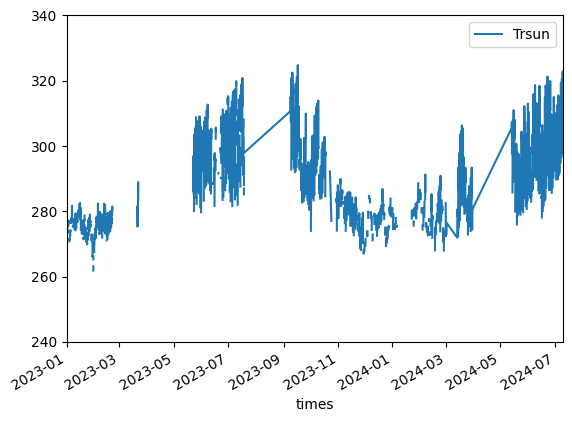

In [25]:
cook_hys.plot(x='times',y=['Trsun'],xlim=xlim,ylim=[240,340])

<Axes: xlabel='times'>

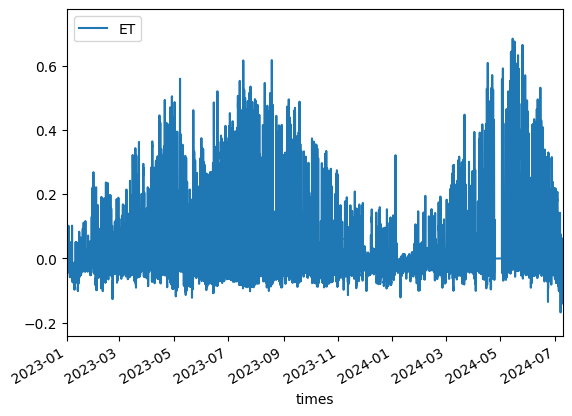

In [26]:
cook_flux.plot(x='times',y=['ET'],xlim=xlim)

In [27]:
cook_hys['times2']=cook_hys['times']
for i in cook_hys.index:
    mask = abs(cook_hys.loc[i,'times']-cook_flux['times'])==min(abs(cook_hys.loc[i,'times']-cook_flux['times']))
    cook_hys.loc[i,'times2'] = cook_flux.loc[mask,'times'].values[0]

In [28]:
cook_hys = cook_hys.drop(columns=['times'])

In [29]:
cook_hys = cook_hys.rename(columns={'times2':'times'}).drop(columns=['index', 'Unnamed: 0'])

In [30]:
cook_hys['times'] = cook_hys.astype({'times':'datetime64[ns]'}).reset_index().times.dt.tz_localize('UTC')

In [31]:
cook_flux = cook_flux.merge(cook_hys,how='left')
cook_flux=cook_flux[cook_flux.times>=cook_hys.times.min()]
cook_flux=cook_flux[cook_flux.times<=cook_hys.times.max()]

In [32]:
inputs = ['elevation', 'azimuth', 'fssun',
       'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd', 'Tssun',
       'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']
outputs = ['ET']

In [33]:
for i in inputs:
    if 'T' in i:
        cook_flux.loc[cook_flux[i]<250,i]=np.nan

In [34]:
bad_ir = cook_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [35]:
cook_flux['BadIR']=bad_ir

In [36]:
cook_flux['Hour']=cook_flux.times.dt.hour

In [37]:
cook_flux = cook_flux.groupby('times').aggregate('mean').reset_index()

In [38]:
cook_flux.to_csv('/90daydata/nsaru/work/CookIRCamET/Working/cook_hys_ec_'+datestr+'.csv',index=False)

In [39]:
cook_flux = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cook_hys_ec_'+datestr+'.csv')

In [40]:
cook_flux_interp = cook_flux.copy().drop_duplicates().sort_values('times')

In [41]:
cook_flux_interp

,times,Year,DoY,Hour,Rg,Tair,rH,VPD,ET,daylight,...,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd,BadIR
0,2022-10-28 22:30:00+00:00,2022.0,301.0,22.0,75.814000,285.5140,38.290270,8.90030,0.011109,1.0,...,0.000000,283.408873,283.885206,283.823653,283.674772,283.583471,283.332070,NaN,NaN,0.0
1,2022-10-28 23:30:00+00:00,2022.0,301.0,23.0,40.734500,284.8185,43.556495,7.77885,-0.014005,0.5,...,0.000144,283.743646,283.880755,283.842943,283.682926,283.760903,283.443550,282.799522,283.089262,0.5
2,2022-10-29 00:30:00+00:00,2022.0,301.0,0.0,17.623450,284.2660,46.636435,7.08660,-0.020946,0.0,...,0.000000,NaN,282.509416,NaN,282.452964,NaN,282.179333,NaN,NaN,0.0
3,2022-10-29 01:30:00+00:00,2022.0,301.0,1.0,0.226791,283.0010,51.168560,5.97920,-0.027209,0.0,...,0.000000,NaN,281.501514,NaN,281.445101,NaN,281.200587,NaN,NaN,0.0
4,2022-10-29 02:30:00+00:00,2022.0,301.0,2.0,0.027994,282.3387,53.903690,5.38635,-0.026846,0.0,...,0.000000,NaN,281.365877,NaN,281.309647,NaN,281.054913,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14894,2024-07-10 12:30:00+00:00,2024.0,192.0,12.0,7.932450,292.9095,44.738415,12.96850,-0.119541,0.0,...,0.000144,NaN,296.357513,NaN,296.352863,NaN,296.466773,NaN,296.435334,0.0
14895,2024-07-10 13:30:00+00:00,2024.0,192.0,13.0,82.451500,294.7170,43.450555,14.61850,-0.134858,0.0,...,0.000144,NaN,296.855460,NaN,296.825696,NaN,296.910703,NaN,296.825175,0.0
14896,2024-07-10 14:30:00+00:00,2024.0,192.0,14.0,220.640000,296.1980,46.035295,15.26000,-0.102488,1.0,...,0.000082,299.441863,299.440011,299.424017,299.457429,299.436185,299.449841,NaN,299.517026,0.0
14897,2024-07-10 15:30:00+00:00,2024.0,192.0,15.0,373.935000,298.0750,46.766080,16.86900,-0.054860,1.0,...,0.000041,302.468438,302.468734,302.427423,302.460939,302.426889,302.431963,NaN,302.442195,0.0


In [42]:
end_idx_0 = cook_flux_interp[cook_flux_interp.times=='2022-11-16 21:30:00+00:00'].index[0]
start_idx_0 = cook_flux_interp[cook_flux_interp.times=='2022-11-27 16:30:00+00:00'].index[0]

end_idx_1 = cook_flux_interp[cook_flux_interp.times=='2023-02-21 01:30:00+00:00'].index[0]
start_idx_1 = cook_flux_interp[cook_flux_interp.times=='2023-03-20 17:30:00+00:00'].index[0]

end_idx_2 = cook_flux_interp[cook_flux_interp.times=='2023-03-22 03:30:00+00:00'].index[0]
start_idx_2 = cook_flux_interp[cook_flux_interp.times=='2023-05-22 17:30:00+00:00'].index[0]

end_idx_3 = cook_flux_interp[cook_flux_interp.times=='2023-07-18 16:30:00+00:00'].index[0]
start_idx_3 = cook_flux_interp[cook_flux_interp.times=='2023-09-08 20:30:00+00:00'].index[0]

end_idx_4 = cook_flux_interp[cook_flux_interp.times=='2024-03-01 17:30:00+00:00'].index[0]
start_idx_4 = cook_flux_interp[cook_flux_interp.times=='2024-03-13 15:30:00+00:00'].index[0]

end_idx_5 = cook_flux_interp[cook_flux_interp.times=='2024-03-30 16:30:00+00:00'].index[0]
start_idx_5 = cook_flux_interp[cook_flux_interp.times=='2024-05-10 22:30:00+00:00'].index[0]

#make chunks around gaps
cook_flux_chunk0 = cook_flux_interp.loc[0:end_idx_0+1,:]
cook_flux_chunk1 = cook_flux_interp.loc[start_idx_0:end_idx_1+1,:]
cook_flux_chunk2 = cook_flux_interp.loc[start_idx_1:end_idx_2+1,:]
cook_flux_chunk3 = cook_flux_interp.loc[start_idx_2:end_idx_3+1,:]
cook_flux_chunk4 = cook_flux_interp.loc[start_idx_3:end_idx_4+1,:]
cook_flux_chunk5 = cook_flux_interp.loc[start_idx_4:end_idx_5+1,:]
cook_flux_chunk6 = cook_flux_interp.loc[start_idx_5:,:]

In [43]:
gb0 = cook_flux_chunk0.groupby(['Year','DoY'])

In [44]:
flux_days0 = [gb0.get_group(g).sort_values('times') for g in gb0.groups if len(gb0.get_group(g))==24]

In [45]:
gb1 = cook_flux_chunk1.groupby(['Year','DoY'])

In [46]:
flux_days1 = [gb1.get_group(g).sort_values('times') for g in gb1.groups if len(gb1.get_group(g))==24]

In [47]:
gb2 = cook_flux_chunk2.groupby(['Year','DoY'])

In [48]:
flux_days2 = [gb2.get_group(g).sort_values('times') for g in gb2.groups if len(gb2.get_group(g))==24]

In [49]:
gb3 = cook_flux_chunk3.groupby(['Year','DoY'])

In [50]:
flux_days3 = [gb3.get_group(g).sort_values('times') for g in gb3.groups if len(gb3.get_group(g))==24]

In [51]:
gb4 = cook_flux_chunk4.groupby(['Year','DoY'])

In [52]:
flux_days4 = [gb4.get_group(g).sort_values('times') for g in gb4.groups if len(gb4.get_group(g))==24]

In [53]:
gb5 = cook_flux_chunk5.groupby(['Year','DoY'])

In [54]:
flux_days5 = [gb5.get_group(g).sort_values('times') for g in gb5.groups if len(gb5.get_group(g))==24]

In [55]:
gb6 = cook_flux_chunk6.groupby(['Year','DoY'])

In [56]:
flux_days6 = [gb6.get_group(g).sort_values('times') for g in gb6.groups if len(gb6.get_group(g))==24]

In [57]:
daily_flux = pd.concat([*flux_days0,*flux_days1,*flux_days2,*flux_days3,*flux_days4,*flux_days5,*flux_days6])[['times','ET', 'Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']].reset_index().drop(columns='index')

In [58]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [59]:
n_feats = len(inputs)

In [60]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [61]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

In [62]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

In [63]:
daily_flux.to_csv('/90daydata/nsaru/work/CookIRCamET/Working/cookhy2023_batches_processed_'+datestr+'.csv', index=False)

In [120]:
daily_flux.groupby('Year').plot.scatter(x='Tsshd',y='Tair',xlim = [250,330],ylim = [250,330])

KeyError: 'Year'

In [76]:
cprl_met_2023_vars = ['NE_Year','NE_DOY','NE_Time in hhmm','NE_Rs in W/m^2','NE_air temp in degrees C','NE_RH in %']
cprl_lys_vars = ['Year','DOY','Tdec','ET (mm)']

#cprl 2024 weather is CDT (5 hours)
#everything else is CST (6 hours)
cprl_met_2024_vars = ['Year','Decimal_DOY','Tdec','Tair (deg C)','RH (%)','Rs (W m-2)']
cprl_swb_vars = ['Year','DOY','Tdec','ET (mm)']

cprl_met_2023 = pd.read_csv("/90daydata/nsaru/raw/CookIRCamET/Meteorological/Cprl/NE_lys_2023_for_Joaquin/2023_NE_Cotton_Lys_ClimDat_New_15_min.csv")[cprl_met_2023_vars]
cprl_met_2023['VPD'] =10*cprl_met_2023.apply(lambda x: vpd(x['NE_air temp in degrees C'],x['NE_RH in %']),axis=1)#hpa

cprl_met_2024 = pd.read_csv("/90daydata/nsaru/raw/CookIRCamET/Meteorological/Cprl/NorthPivot_2024/Weather_qc_qa/npvt_2024_weather_qc_15_min.csv")[cprl_met_2024_vars]
cprl_met_2024['VPD'] = 10*cprl_met_2024.apply(lambda x: vpd(x['Tair (deg C)'],x['RH (%)']),axis=1)#hpa

In [77]:
cprl_met_2024['DoY'] = cprl_met_2024.apply(
    lambda x: np.floor((x["Decimal_DOY"] - 1)),
    axis=1,
)

cprl_met_2024['Date'] = cprl_met_2024.apply(
    lambda x: pd.to_datetime(x["Year"], format="%Y")
    + pd.DateOffset(days=x["DoY"], hours=x["Tdec"]),
    axis=1,
)

cprl_met_2024['Date'] = cprl_met_2024.apply(
    lambda x: x["Date"] - pd.DateOffset(hours=1),#to cst
    axis=1,
)
cprl_met_2024['HHMM'] = cprl_met_2024.apply(
    lambda x: datetime.datetime.strftime(x["Date"],"%H%M"),
    axis=1,
)

cprl_met_2024['DoY'] = cprl_met_2024.DoY + 1

cprl_met_2024['HHMM'] = cprl_met_2024.HHMM.astype('int')

cprl_met_2024 = cprl_met_2024.drop(columns=['Tdec' ,'Decimal_DOY','Date'])

In [78]:
cprl_met_2023 = cprl_met_2023.rename(columns={'NE_Year':'Year','NE_DOY':'DoY','NE_Time in hhmm':'HHMM','NE_Rs in W/m^2':'Rg','NE_air temp in degrees C':'Tair','NE_RH in %':'rH'})

In [79]:
cprl_met_2024 = cprl_met_2024.rename(columns={'Rs (W m-2)':'Rg','Tair (deg C)':'Tair','RH (%)':'rH'})

In [80]:
cprl_met = pd.concat([cprl_met_2023,cprl_met_2024])

In [81]:
cprl_met_2023.DoY

0          1
1          1
2          1
3          1
4          1
        ... 
35035    365
35036    365
35037    365
35038    365
35039    365
Name: DoY, Length: 35040, dtype: int64

In [82]:
 
cprl_lys = pd.read_csv("/90daydata/nsaru/raw/CookIRCamET/Meteorological/Cprl/NE_lys_updated_2023/2023_NE_Cotton_water_balance_15_min_matlab.csv")[cprl_lys_vars]

In [83]:
cprl_hy2023_v1 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprlhy2023_V1_pa_output.csv')
cprl_hy2023_v2 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprlhy2023_V2_pa_output.csv')
cprl_hy2024_v3 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprlhy2024_V3_pa_output.csv')
cprl_hys = pd.concat([cprl_hy2023_v1,cprl_hy2023_v2,cprl_hy2024_v3]).reset_index()#.astype({'times':'datetime64'})

In [84]:
cprl_hys.times

0       2023-04-11 19:21:31+00:00
1       2023-04-11 19:51:36+00:00
2       2023-04-11 20:21:42+00:00
3       2023-04-11 20:51:47+00:00
4       2023-04-11 21:21:53+00:00
                  ...            
8289    2024-10-06 13:40:43+00:00
8290    2024-10-06 14:40:48+00:00
8291    2024-10-06 15:40:54+00:00
8292    2024-10-06 16:40:58+00:00
8293    2024-10-06 17:41:03+00:00
Name: times, Length: 8294, dtype: object

In [85]:
cprl_hys['times'] = pd.to_datetime(cprl_hys.times)#.dt.tz_localize('UTC')
cprl_hys = cprl_hys[['times', 'daylight', 'elevation', 'azimuth',
       'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd',
       'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']]

In [86]:
cprl_lys = cprl_lys.rename(columns={'DOY':'DoY','Tdec':'Hour','ET (mm)':'ET'})

In [87]:
cprl_lys['Minutes']=60*(cprl_lys['Hour']-np.floor(cprl_lys['Hour']))
cprl_lys['Minutes']=cprl_lys['Minutes'].astype(int).astype(str)
cprl_lys['Hour']=np.floor(cprl_lys['Hour']).astype(int).astype(str)

In [88]:
mask = cprl_lys.Hour=='24'
cprl_lys.loc[mask,'Hour']='0'
cprl_lys.loc[mask,'DoY']=cprl_lys.loc[mask,'DoY']+1

In [89]:
mask = cprl_lys.DoY==366
cprl_lys.loc[mask,'DoY']=1
cprl_lys.loc[mask,'Year']=2024

In [90]:
cprl_met['Hour'] = np.floor(cprl_met.HHMM/100).astype(int).astype(str)
cprl_met['Minutes'] = 100*(cprl_met.HHMM/100 - np.floor(cprl_met.HHMM/100))
cprl_met['Minutes'] = cprl_met.Minutes.astype(int).astype(str)
cprl_met['Minutes']=cprl_met.Minutes.replace({'14':'15','44':'45'})

In [91]:
mask = cprl_met.Hour=='24'
cprl_met.loc[mask,'Hour']='0'
cprl_met.loc[mask,'DoY']=cprl_met.loc[mask,'DoY']+1

In [92]:
mask = cprl_met.DoY==366
cprl_met.loc[mask,'DoY']=1
cprl_met.loc[mask,'Year']=cprl_met.loc[mask,'Year']+1

In [93]:
cprl_met['Date'] = cprl_met.apply(lambda x: datetime.datetime.strptime(str(x['Year'])+'-'+str(int(x['DoY']))+'-'+str(x['Hour'])+':'+str(x['Minutes']),'%Y-%j-%H:%M'),axis=1)

In [94]:
cprl_met.Date

0       2023-01-01 00:15:00
1       2023-01-01 00:30:00
2       2023-01-01 00:45:00
3       2023-01-01 01:00:00
4       2023-01-01 01:15:00
                ...        
35131   2025-01-01 21:45:00
35132   2025-01-01 22:00:00
35133   2025-01-01 22:15:00
35134   2025-01-01 22:30:00
35135   2025-01-01 22:45:00
Name: Date, Length: 70176, dtype: datetime64[ns]

Year
2023    Axes(0.125,0.11;0.775x0.77)
2024    Axes(0.125,0.11;0.775x0.77)
2025    Axes(0.125,0.11;0.775x0.77)
dtype: object

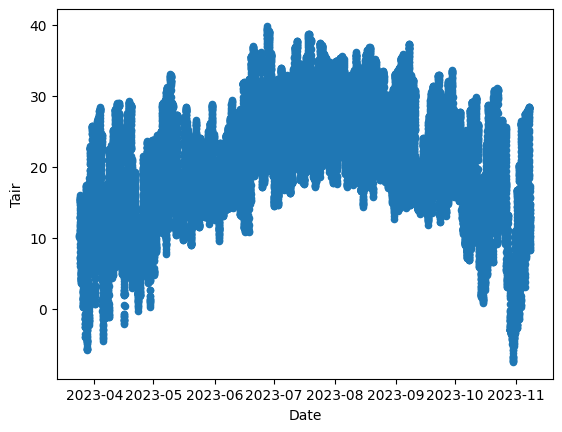

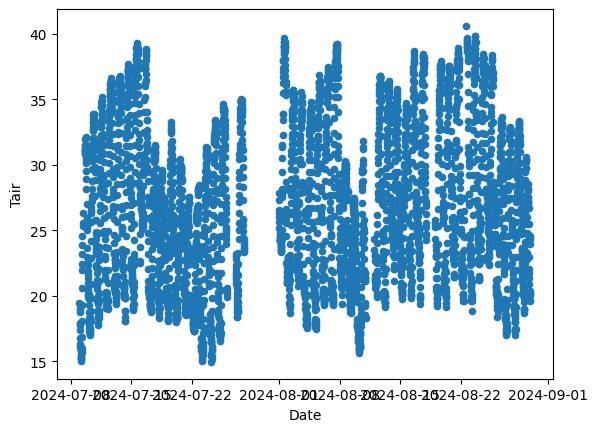

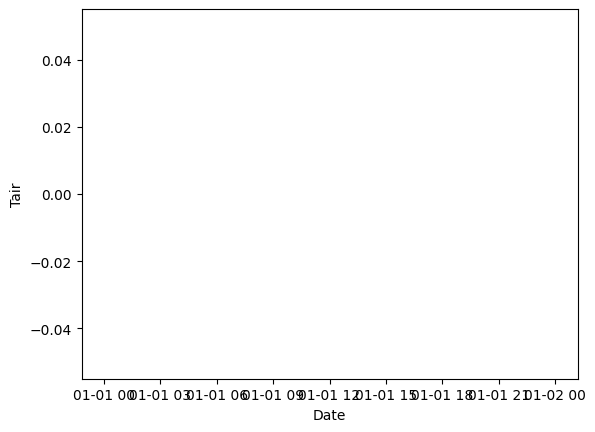

In [95]:
cprl_met.groupby('Year').plot.scatter(x='Date',y='Tair')


<Axes: xlabel='Date'>

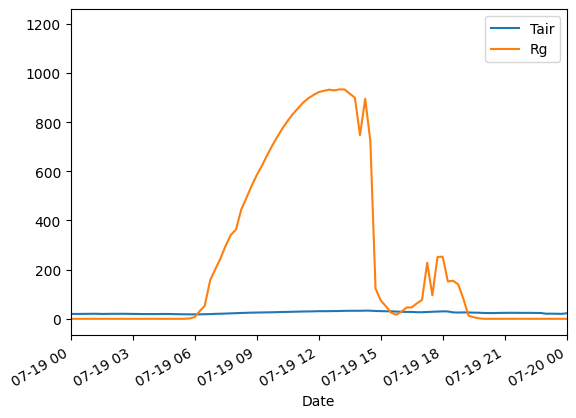

In [96]:
xlim=[pd.to_datetime('2024-07-19 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2024-07-20 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_met.plot(x='Date',y='Tair')
cprl_met.plot(x='Date',y=['Rg'],xlim=xlim,ax=ax)

In [97]:
cprl_met_lys=cprl_met.merge(cprl_lys,on=['Hour','Minutes','Year','DoY'],how='left')

In [98]:
cprl_met_lys=cprl_met_lys.groupby(['Year','DoY','Hour']).agg({'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'ET':'sum','VPD':'mean'}).reset_index(drop=False)

In [99]:
cprl_met_lys['times']=pd.to_datetime(cprl_met_lys['Year'].astype(str) + ' ' + cprl_met_lys['DoY'].astype('int').astype(str) + ' ' + cprl_met_lys['Hour']+':'+'00',
    format='%Y %j %H:%M'
   )

In [100]:
cprl_met_lys.Tair+=273.15

In [101]:
cprl_met_lys

,Year,DoY,Hour,Rg,Tair,rH,ET,VPD,times
0,2023,1.0,0,NaN,NaN,NaN,0.065940,NaN,2023-01-01 00:00:00
1,2023,1.0,1,NaN,NaN,NaN,-0.142809,NaN,2023-01-01 01:00:00
2,2023,1.0,10,NaN,NaN,NaN,0.040944,NaN,2023-01-01 10:00:00
3,2023,1.0,11,NaN,NaN,NaN,0.128769,NaN,2023-01-01 11:00:00
4,2023,1.0,12,NaN,NaN,NaN,0.097980,NaN,2023-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...
17539,2025,1.0,5,NaN,NaN,NaN,0.000000,NaN,2025-01-01 05:00:00
17540,2025,1.0,6,NaN,NaN,NaN,0.000000,NaN,2025-01-01 06:00:00
17541,2025,1.0,7,NaN,NaN,NaN,0.000000,NaN,2025-01-01 07:00:00
17542,2025,1.0,8,NaN,NaN,NaN,0.000000,NaN,2025-01-01 08:00:00


In [102]:
cprl_met_lys['times'] = cprl_met_lys.times.dt.tz_localize('Etc/GMT+6')

In [103]:
cprl_met_lys['times'] = cprl_met_lys.times.dt.tz_convert('UTC')

In [104]:
cprl_hys['times2']=cprl_hys['times']
for i in cprl_hys.index:
    mask = abs(cprl_hys.loc[i,'times']-cprl_met_lys['times'])==min(abs(cprl_hys.loc[i,'times']-cprl_met_lys['times']))
    cprl_hys.loc[i,'times2'] = cprl_met_lys.loc[mask,'times'].values[0]

In [105]:
cprl_hys = cprl_hys.drop(columns=['times']).rename(columns={'times2':'times'})

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [106]:
cprl_hys= cprl_hys.astype({'times':'datetime64[ns]'}).reset_index(drop=True)

In [107]:
cprl_hys['times'] = cprl_hys.times.dt.tz_localize('UTC')

In [108]:
cprl_hys = cprl_hys.groupby(['times']).agg({'daylight':'mean', 'elevation':'mean', 'azimuth':'mean',
       'fssun':'mean', 'fsshd':'mean', 'frsun':'mean', 'frshd':'mean', 'fvsun':'mean', 'fvshd':'mean', 'fwsun':'mean', 'fwshd':'mean',
       'Tssun':'mean', 'Tsshd':'mean', 'Trsun':'mean', 'Trshd':'mean', 'Tvsun':'mean', 'Tvshd':'mean', 'Twsun':'mean', 'Twshd':'mean'}).reset_index(drop=False) 

In [109]:
cprl_flux = cprl_met_lys.merge(cprl_hys,how='left',on = 'times')

In [110]:
cprl_flux

,Year,DoY,Hour,Rg,Tair,rH,ET,VPD,times,daylight,...,fwsun,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd
0,2023,1.0,0,NaN,NaN,NaN,0.065940,NaN,2023-01-01 06:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,1.0,1,NaN,NaN,NaN,-0.142809,NaN,2023-01-01 07:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,1.0,10,NaN,NaN,NaN,0.040944,NaN,2023-01-01 16:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,1.0,11,NaN,NaN,NaN,0.128769,NaN,2023-01-01 17:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,1.0,12,NaN,NaN,NaN,0.097980,NaN,2023-01-01 18:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2025,1.0,5,NaN,NaN,NaN,0.000000,NaN,2025-01-01 11:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17540,2025,1.0,6,NaN,NaN,NaN,0.000000,NaN,2025-01-01 12:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17541,2025,1.0,7,NaN,NaN,NaN,0.000000,NaN,2025-01-01 13:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17542,2025,1.0,8,NaN,NaN,NaN,0.000000,NaN,2025-01-01 14:00:00+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Year
2023    Axes(0.125,0.11;0.775x0.77)
2024    Axes(0.125,0.11;0.775x0.77)
2025    Axes(0.125,0.11;0.775x0.77)
dtype: object

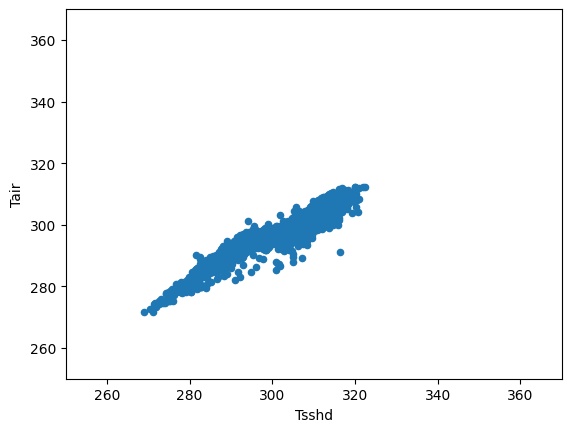

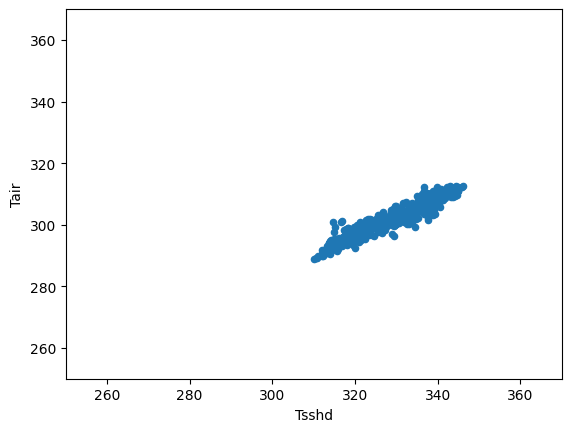

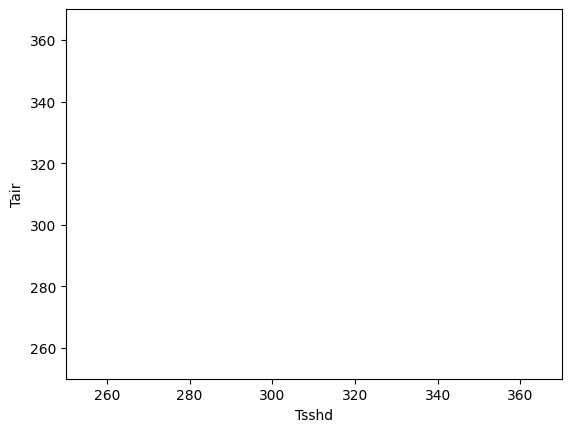

In [119]:
cprl_flux.groupby('Year').plot.scatter(x='Tsshd',y='Tair',xlim = [250,370],ylim = [250,370])

In [116]:
ax


Year
2023    Axes(0.125,0.11;0.775x0.77)
2024    Axes(0.125,0.11;0.775x0.77)
2025    Axes(0.125,0.11;0.775x0.77)
dtype: object

In [ ]:
#timezone check & "good chunks"
xlim_list = []

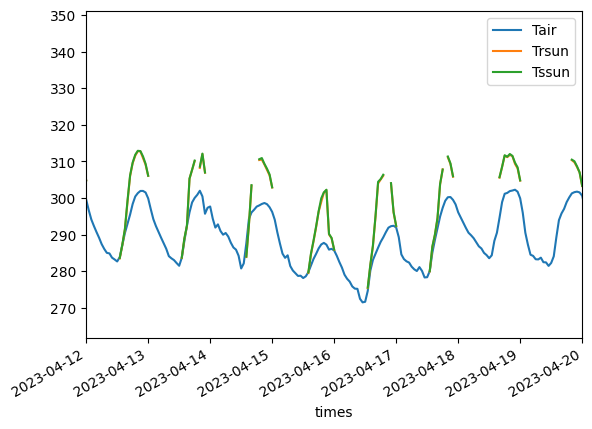

In [225]:
xlim=[pd.to_datetime('2023-04-12 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-04-20 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

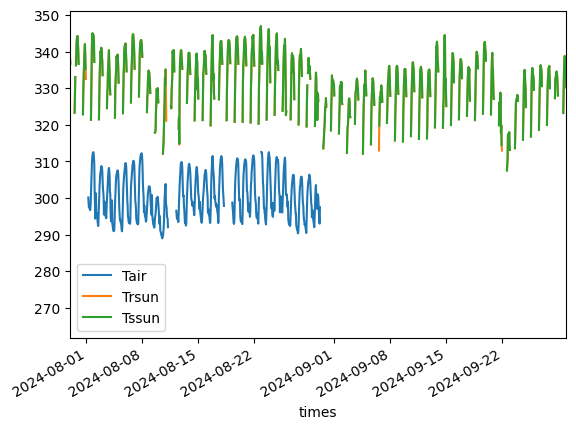

In [237]:
xlim=[pd.to_datetime('2024-07-30 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2024-09-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

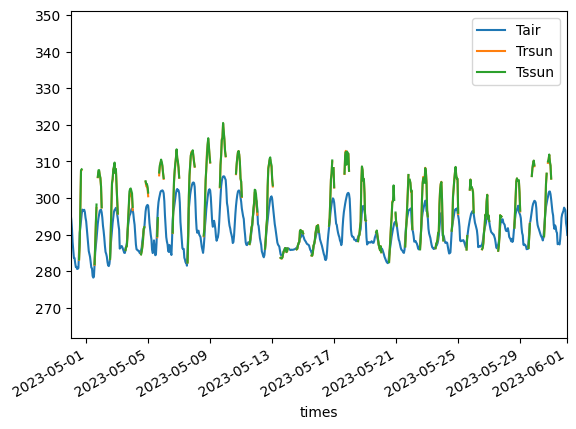

In [226]:
xlim=[pd.to_datetime('2023-04-30 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-06-01 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_met_lys.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

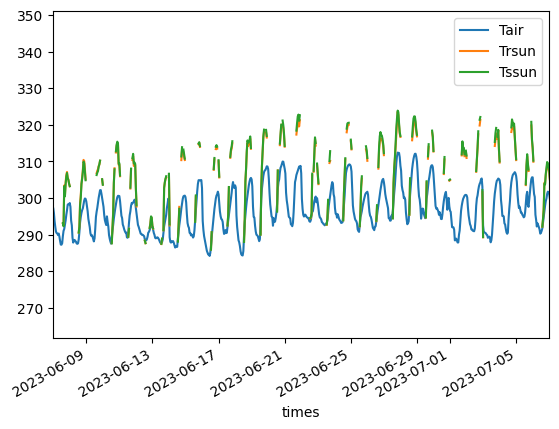

In [227]:
xlim=[pd.to_datetime('2023-06-07 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-07 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

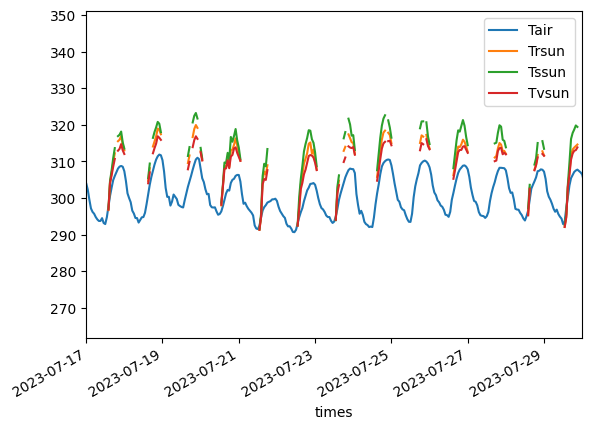

In [228]:
xlim=[pd.to_datetime('2023-07-17 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

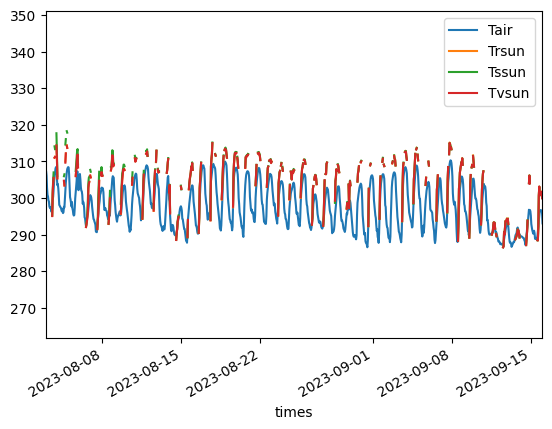

In [229]:
xlim=[pd.to_datetime('2023-08-03 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-09-16 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

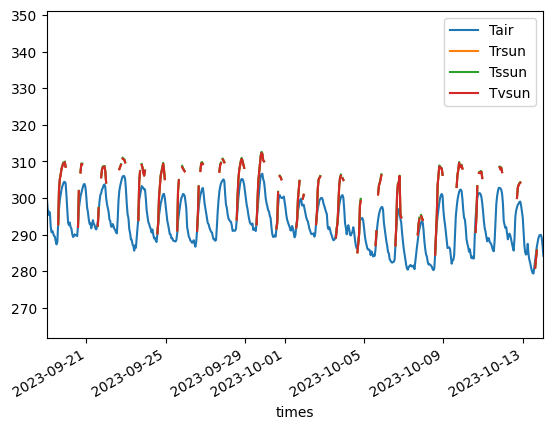

In [230]:
xlim=[pd.to_datetime('2023-09-19 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-10-14 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

In [231]:
for i in inputs:
    if 'T' in i:
        cprl_flux.loc[cprl_flux[i]<250,i]=np.nan

In [ ]:
bad_ir = cprl_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [ ]:
cprl_flux['BadIR']=bad_ir

In [ ]:
cprl_flux

In [ ]:
cprl_flux = cprl_flux.sort_values('times').reset_index(drop=True)

In [ ]:
chunks = []
gbs = []
fds = []

In [ ]:
for xlim in xlim_list:
    print(xlim)
    start_idx = cprl_flux[cprl_flux.times==xlim[0].tz_localize('UTC')].index[0]
    end_idx = cprl_flux[cprl_flux.times==xlim[1].tz_localize('UTC')].index[0]
    print(start_idx,end_idx)
    #make chunks
    cprl_flux_chunks=cprl_flux.loc[start_idx:end_idx+1,:]
    chunks.append(cprl_flux_chunks)
    gb=cprl_flux_chunks.groupby(['Year','DoY'])
    gbs.append(gb)
    fds.append([gb.get_group(g).sort_values('times') for g in gb.groups if len(gb.get_group(g))==24])

In [ ]:
fds = [f
       for fd in fds
       for f in fd ]

In [ ]:
daily_flux = pd.concat(fds).reset_index(drop=True)

In [ ]:
daily_flux = daily_flux[['times','ET', 'Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']]

In [ ]:
inputs = ['Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [ ]:

n_feats = len(inputs)

In [ ]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [ ]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

In [ ]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='ET',xlim=xlim)

In [ ]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [ ]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

In [ ]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [ ]:
daily_flux.to_csv('../../work/CookIRCamET/Working/cprlhy2023_batches_processed_'+datestr+'.csv', index=False)